In [ ]:
#@title Текст заголовка по умолчанию
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 

import pyarrow.parquet as pq

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datafusionusurt/data_fusion_train.parquet
/kaggle/input/receipt/data_fusion_task1_train.ipynb
/kaggle/input/receipt/data_fusion_answers_1.csv
/kaggle/input/receipt/data_fusion_t1_sub/script.py
/kaggle/input/receipt/data_fusion_t1_sub/clf_task1
/kaggle/input/receipt/data_fusion_t1_sub/tfidf


In [ ]:
import matplotlib.pyplot as plt
import random
from collections import Counter

# Work with text
import re
import nltk.data
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Прочитаем данные, удалив дубликаты и неразмеченные данные.

In [ ]:
train = pd.read_parquet('../input/datafusionusurt/data_fusion_train.parquet')[['item_name', 'category_id']]
train = train[train.category_id != -1].drop_duplicates('item_name')

In [ ]:
train

,item_name,category_id
1,"Молоко 3,2%,шт",78
3,"Компот из изюма, 114 ккал",71
4,"Макаронные изделия отварные (масло сливочное),...",71
17,Кофе Капучино Большой Эден 18,70
40,Хлеб на СЫВОРОТКЕ 350г,84
...,...,...
45669181,"Напиток Энерг. Ред Булл 0,355л",83
45681543,Хеменгуэй Дайкири,0
45690702,"Пиво светлое ""Халзан"" 4,5 % об, пл/б. 1,5 л(шт)",0
45692298,Экспресс педикюр,42


In [ ]:
train.category_id.value_counts()

84     7094
71     4771
78     2869
83     2865
0      2356
       ... 
102      19
101      17
46       15
100      14
97       13
Name: category_id, Length: 96, dtype: int64

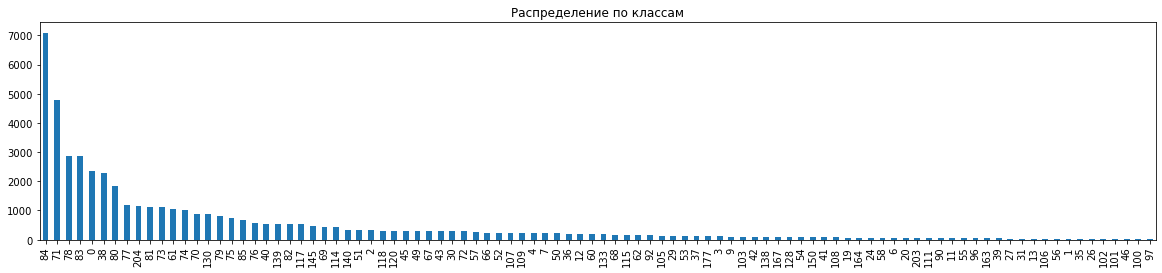

In [ ]:
train.category_id.value_counts().plot.bar(figsize=(20, 4))
plt.title('Распределение по классам');

In [ ]:
train[train['category_id'] == 4]

,item_name,category_id
11212,ЦИЛИНДР ТОРМ ПЕРЕДНИЙ ЛЕВЫЙ,4
24330,Крышка радиатора,4
27446,ЗОЛОТНИКИ КОРОТКИЕ С ПЛАСТ КОЛПАЧКАМИ 5ШТ+ КЛЮЧ,4
28758,Диск тормозной,4
28759,Полуступица,4
...,...,...
43728531,Трубка омывателя прозрачная 50м. 03*06мм. (1метр),4
44011706,подшипник 111,4
44015351,Глушитель ВАЗ 2104 закатной инжектор,4
44707038,"Крышка расширительного бачка (Г-, Г-3302) /ор...",4


In [ ]:
train[train['category_id'] == 67]

,item_name,category_id
15704,Блюдо Стол Суши 1299,67
22644,"""Калифорния""",67
22645,"""Филадельфия """,67
24066,Набор Рич Дэдди,67
24067,Ролл Острый Окунь БЛ,67
...,...,...
40875376,"Мини Ролл"" Классический с огурцом""",67
41166749,Калифорния с креветкой NEW,67
43950959,Ролл запеченый краб,67
44237580,3 Акция Ролл Филадельфия темпура - 115 руб.,67


In [ ]:
train[train['category_id'] == 77]

,item_name,category_id
417,230Г СОУС КАЛЬВЕ СЛАДКИЙ ЧИЛИ,77
744,Соус Сырный шт.,77
775,Хрен столовый Трофимыч 130г Юдинцев,77
813,"ВАНИЛИН 1,5 Г ХААС",77
948,САХАР 900 Г ПЕСОК,77
...,...,...
43740784,Гвоздика целая 10гр,77
43937274,Соус белый 50г 2 порц.,77
44308387,ПРИПРАВА ПЕРЕЦ ЧИЛИ 20Г,77
45405277,"Масло миндальное 0,1л 1/16 ""Житница здоровья""",77


#### Препроцессинг может включать следующие шаги:
* перевод в нижний регист
* удаление стоп-слов, 
* удаление знаков пунктуации
* стемминг
* извлечение чисел
* удаление часто/редко встречающихся слов
* преобразование сокращений

In [ ]:
stop_words = stopwords.words("russian")
stop_words[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
words_only = re.compile('[а-яa-z]+')

def letters(s, regex = words_only):
    if isinstance(s, str):
        return words_only.findall(s.lower())
    else:
        return []
    
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(tokens, sw = stop_words):
    return [t for t in tokens if not t in sw]

def preprocess(s):
    return remove_stopwords(letters(s))

In [ ]:
train['item_name'] = train['item_name'].apply(lambda text: remove_punctuation(text))
train['clean_item_name'] = train['item_name'].apply(preprocess)

In [ ]:
train.sample(10)

,item_name,category_id,clean_item_name
2723021,Ремонт одежды,61,"[ремонт, одежды]"
5653,Жевательная резинка Орбит Bubblemint белоснежн...,84,"[жевательная, резинка, орбит, bubblemint, бело..."
1156919,Мармелад желейный формовой Мар,84,"[мармелад, желейный, формовой, мар]"
1938,ЧИПСЫ КУКУР В АССОРТ,81,"[чипсы, кукур, ассорт]"
501184,Напиток Монастырский 05л спорт пэт,83,"[напиток, монастырский, л, спорт, пэт]"
22602,Хлеб пшеничный ПП 35 г,84,"[хлеб, пшеничный, пп, г]"
2208772,саморез металлметалл 42х16,109,"[саморез, металлметалл, х]"
18295493,Бумага двыпечки Фрау Марта 6м,130,"[бумага, двыпечки, фрау, марта, м]"
17891,Л Сосиска в тесте 1 шт ГЕ,84,"[л, сосиска, тесте, шт, ге]"
2473860,Кубик Кнорр Куриный 10г домашний 36,77,"[кубик, кнорр, куриный, г, домашний]"


In [ ]:
train['numbers'] = train['item_name'].str.extract(r'([0-9]+)', expand=True)

In [ ]:
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer('russian')
from functools import lru_cache

In [ ]:
def stemm_description(d):
    @lru_cache(maxsize=128)
    def stemm_token(token):
        return snowball.stem(token)  
    return[stemm_token(t) for t in d if len(stemm_token(t)) >= 3]

In [ ]:
cnt = Counter()
for text in train['item_name'].values:
    for word in text.split():
        cnt[word] += 1

In [ ]:
common=[]
for k,v in cnt.most_common():
    if (len(k) < 3) & (v > 100):
        common.append(k)
random.choices(common, k=10)

['02', 'кг', 'за', '45', '20', 'см', 'в', '2', 'СП', 'БЛ']

In [ ]:
rare=[]
for k,v in cnt.most_common():
    if (len(k) >= 5) & (v <= 1):
        rare.append(k.lower())
random.choices(rare, k=10)

['мираж',
 'metro',
 'куртка',
 'коппа',
 'x100мм',
 '091809',
 'зеленоградский',
 '10025мг',
 'кусклуббазил',
 '70100см']

In [ ]:
def remove_common(text):
    return " ".join([word for word in str(text).split() if word not in common])
def remove_rarewords(text):
    return ([word for word in text if word not in rare])

In [ ]:
train["item_name01"] = train["clean_item_name"].apply(lambda text: remove_rarewords(text))
train["item_name01"] = train["item_name01"].apply(lambda text: remove_common(text))

In [ ]:
#@title Текст заголовка по умолчанию
train.sample(10)
#необходимо точечно настраивать редкие/частые слова

,item_name,category_id,clean_item_name,numbers,item_name01
645643,ИБУКЛИН 040325 N10 ТАБЛ ППЛЕНОБОЛОЧ Др Редди с...,38,"[ибуклин, n, табл, ппленоболоч, др, редди, лаб...",040325,"['ибуклин', 'n', 'табл', 'др', 'лабораторис', ..."
200522,Хлебцы Волжские 2х50г Хлебнаш,84,"[хлебцы, волжские, х, г, хлебнаш]",2,"['хлебцы', 'волжские', 'х', 'г', 'хлебнаш']"
11999,05Л МИН ВОДА БОРЖОМИ ГАЗ ПЭТ,83,"[л, мин, вода, боржоми, газ, пэт]",05,"['л', 'мин', 'вода', 'боржоми', 'газ', 'пэт']"
6159271,Донат с начинкой в ассорт,84,"[донат, начинкой, ассорт]",NaN,['начинкой']
523550,Не имбирь мне мозги шт,71,"[имбирь, мозги, шт]",NaN,"['имбирь', 'шт']"
6462365,Кофе Американо 200мл NC,70,"[кофе, американо, мл, nc]",200,"['кофе', 'американо', 'мл', 'nc']"
16801,КИТЕКЕТ рыба в соусе пауч 8,145,"[китекет, рыба, соусе, пауч]",8,"['китекет', 'рыба', 'соусе', 'пауч']"
23368614,Five Lakes 1 порц,0,"[five, lakes, порц]",1,"['five', 'порц']"
48846,Сосиски Добрый мишка 500г газуп Доброе дело,74,"[сосиски, добрый, мишка, г, газуп, доброе, дело]",500,"['сосиски', 'г', 'газуп', 'доброе', 'дело']"
151615,Сковорода Три мяса,71,"[сковорода, мяса]",NaN,"['сковорода', 'мяса']"


In [1]:
#@title reduc_words_str
#случайно выбранные сокращения
reduc_words_str ="""
кг=килограмм
г=грамм
гр=грамм
л=литр
мл=миллилитр
шт=штука
ккал=килокаллории
плб=пластиковая бутылка
таб=таблетка
мг=миллиграмм 
мм=миллиметр
м=метр
ге=готовое изделие
стб=стеклянная бутылка
"""

In [ ]:
reduc_words_map_dict = {}
reduc_words_list = []
for line in reduc_words_str.split("\n"):
    if line != "":
        rw = line.split("=")[0]
        rw_expanded = line.split("=")[1]
        reduc_words_list.append(rw)
        reduc_words_map_dict[rw] = rw_expanded
reduc_words_list = set(reduc_words_list)

def reduc_words_conversion(text):
    new_text = []
    for w in text:
        if w in reduc_words_list:
            new_text.append(reduc_words_map_dict[w])
        else:
            new_text.append(w)
    return (new_text)

In [ ]:
train['clean_item_name'] = train['clean_item_name'].apply(reduc_words_conversion)
train['stemmed'] = train['clean_item_name'].apply(stemm_description)

In [ ]:
train.sample(10)

,item_name,category_id,clean_item_name,numbers,item_name01,stemmed
38854671,фонарикмаячок безопасности ФО,103,"[фонарикмаячок, безопасности, фо]",NaN,['фо'],"[фонарикмаячок, безопасн]"
1721365,Байский чай 500мл,70,"[байский, чай, миллилитр]",500,"['байский', 'чай', 'мл']","[байск, миллилитр]"
131935,Сыр Голландский 45 газуп,78,"[сыр, голландский, газуп]",45,"['сыр', 'голландский', 'газуп']","[сыр, голландск, газуп]"
22542678,2 Акция Ролл Филадельфия темпура 115 руб,67,"[акция, ролл, филадельфия, темпура, руб]",2,"['акция', 'ролл', 'темпура', 'руб']","[акц, ролл, филадельф, темпур, руб]"
5511512,шар елочный 12 см глиттер зол,118,"[шар, елочный, см, глиттер, зол]",12,"['шар', 'см', 'зол']","[шар, елочн, глиттер, зол]"
11995909,ФН Каша овсяная с мол яблбанан 200г кор,72,"[фн, каша, овсяная, мол, яблбанан, грамм, кор]",200,"['фн', 'каша', 'мол', 'г', 'кор']","[каш, овсян, мол, яблбана, грамм, кор]"
45963,ДРАЖЕ АРАХИС В КАКАО ПОРОШКЕ 200Г,84,"[драже, арахис, какао, порошке, грамм]",200,"['драже', 'арахис', 'какао', 'г']","[драж, арахис, кака, порошк, грамм]"
33549861,2 Контейнер дпROYALGZE46,130,"[контейнер, дпroyalgze]",2,"['контейнер', 'дпroyalgze']","[контейнер, дпроыалгз]"
14490991,Булочка Яблочная с изюмом,84,"[булочка, яблочная, изюмом]",NaN,"['булочка', 'изюмом']","[булочк, яблочн, изюм]"
1171578,Блин Охотничьи колбаски 200 гр 1 шт,71,"[блин, охотничьи, колбаски, грамм, штука]",200,"['блин', 'колбаски', 'гр', 'шт']","[блин, охотнич, колбаск, грамм, штук]"


In [ ]:
train.drop(['clean_item_name', 'item_name01'], 1)

,item_name,category_id,numbers,stemmed
1,Молоко 32шт,78,32,"[молок, штук]"
3,Компот из изюма 114 ккал,71,114,"[компот, изюм, килокаллор]"
4,Макаронные изделия отварные масло сливочное 24...,71,240,"[макарон, издел, отварн, масл, сливочн, килока..."
17,Кофе Капучино Большой Эден 18,70,18,"[коф, капучин, больш]"
40,Хлеб на СЫВОРОТКЕ 350г,84,350,"[хлеб, сыворотк, грамм]"
...,...,...,...,...
45669181,Напиток Энерг Ред Булл 0355л,83,0355,"[напиток, энерг, ред, булл, литр]"
45681543,Хеменгуэй Дайкири,0,NaN,"[хеменгуэ, дайкир]"
45690702,Пиво светлое Халзан 45 об плб 15 лшт,0,45,"[пив, светл, халза, пластиковая бутылк, лшт]"
45692298,Экспресс педикюр,42,NaN,"[экспресс, педикюр]"
